In [96]:
import math
from py_vollib.black_scholes_merton  import black_scholes_merton
from utilsJupyter import * 
base=.25   

In [97]:
import datetime
# add holding until Tuesday or Wednesday for losing trades
# train & predict on 1000 stocks & get top 100 high & low float stocks
    
global_deltas = {}
rets = {}
profits = {}
accs = {}
# need a better simulation of legging into a 
for symbol in symbols:
    try:
        __df = data[symbol]
    except:
        continue
    only = __df.iloc[-200:]
    o=0
    n=0
    profit = 0
    principle = 1000

    #only = only[(only['real_pred']-.5).abs()<.2]
    acc = only.was_right.mean()
    avg_price = only['price'].mean()
    avg_delta_when_correct = only[only['was_right']==1].reg.abs().mean()
    avg_delta_when_wrong = only[only['was_right']==0].reg.abs().mean()
    
    deltas = []
    for row in only.iterrows():
        index = row[0]
        date = index
        next_row = only.shift(-1).loc[index]
        next_price = next_row.price
        row = row[1]
        price = row.price
        pred = row.real_pred
        dt = index_to_dt(index)
        
        if not dt.weekday()==4:
            continue
            
        #print(index)
            
        if pred<.5:
            strike=ceil(price) # strike
        else:
            strike=floor(price)
            
        time = 1/52
        upper = ceil(price)
        lower = floor(price)
        try:
            enter_bps = bull_put_spread(price, upper, lower, time)
            enter_bcs = bear_call_spread(price, upper, lower, time)

            time= 1/52 - 3/365
            #exit_bps = bull_put_spread(next_price, upper, lower ,time)
            #exit_bcs = bear_call_spread(next_price, upper, lower,time)
            exit_bps = 1
            exit_bcs = 1
        except:
            continue
            
        
        for k in range(2):
            if row.real_pred>.5:
                delta = enter_bps/exit_bps
            else:
                delta = enter_bcs/exit_bcs
                
            if delta<1:
                time-=1/365
                if time < 0:
                    time = 0
                next_row = only.shift(-2-k).loc[index]
                next_price = next_row.price
                exit_bps = bull_put_spread(next_price, upper, lower ,time)
                exit_bcs = bear_call_spread(next_price, upper, lower,time)
            else:
                break
            
        
        if delta > 1:
            o += 1
        n += 1

        if not np.isnan(delta):
            profit += principle * (delta-1)
        deltas.append(delta)
    ret=1
    for delta in deltas:
        if np.isnan(delta):
            continue
        ret *= delta
        
    rets[symbol] = ret
    global_deltas[symbol] = deltas
    profits[symbol] = profit
    try:
        acc = o/n
        accs[symbol] = acc
    except:
        acc = 'N/A'
    
    #print(symbol)
    #print(f'acc {acc}')
    #print(f'correct {avg_delta_when_correct}')
    #print(f'wrong {avg_delta_when_wrong}')
    #print(f'count {only.count()}')
    #print(f'return {ret}')
    #print(f'profit {profit}')
    #print('\n')
    #print(deltas)
print('DONE')

/Users/p/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in double_scalars
  # This is added back by InteractiveShellApp.init_path()
/Users/p/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


DONE


In [48]:
ops = pd.read_csv('./ops.csv')
ops = ops.set_index('Symbol')

In [51]:
ops.loc['AMD']['Options Vol.']

651963

In [72]:
o=0
sum_mean = 0
product_mean= 1
for symbol in profits:
    ret = profits[symbol]/1000
    #print(ret)
    sum_mean += ret
    product_mean *= ret
    if ret > 1 :
        o+=1
#print(f'product mean {product_mean**(1/len(rets))}')
#print(f'summed mean {sum_mean/len(rets)}')
o/len(rets)

0.64859228362878

In [79]:
_deltas = []
n=0
o=0
for symbol in profits:
    vol = ops.loc[symbol]['Options Vol.']
    if vol > 1000:
        prof = 1
        deltas = global_deltas[symbol]
        
        for delta in deltas:
            if (not np.isnan(delta)) and (prof>0):
                prof *= delta
                
        profit = (symbol, prof, vol)
        _deltas.append(profit)
        if prof > 1:
            o+=1
        n+=1
    
_deltas = sorted(_deltas, key = lambda x: -x[1])

print(o/n)
_deltas

0.7421602787456446


[('APRN', 50399.21696706519, 1909),
 ('NGD', 31766.336414077974, 1953),
 ('GERN', 27897.13508438343, 1006),
 ('CRON', 15746.556781151157, 34465),
 ('SPWR', 2207.52167098885, 3248),
 ('BTE', 1319.5633671677533, 1639),
 ('FRAN', 859.4431988992502, 6274),
 ('DNR', 405.1760559824974, 12468),
 ('USAT', 299.1631590646397, 1217),
 ('AUY', 249.04077901529305, 6321),
 ('TXMD', 240.57784184873793, 1304),
 ('NTRI', 233.90075228836264, 1810),
 ('GALT', 201.91928811029388, 2264),
 ('NVAX', 201.3198497566973, 2212),
 ('AG', 174.5423121949615, 2274),
 ('TSLA', 166.02724914362096, 277356),
 ('CYH', 100.46727659265582, 1869),
 ('XOG', 82.50615480029987, 2370),
 ('NKTR', 80.30971451494995, 2751),
 ('KGC', 77.57693168228865, 1241),
 ('JCP', 64.42345590722084, 10931),
 ('VHC', 59.74457674408775, 1291),
 ('TLRD', 57.92910142772866, 4867),
 ('CDE', 57.52467960923039, 1761),
 ('NBR', 55.08484912637499, 13705),
 ('ROKU', 50.32316332587381, 8392),
 ('NTNX', 49.924336646760054, 5377),
 ('AU', 47.44236526804723,

In [74]:
# large implied volatility
# option volume
# predictability
# create a model for Monday to Friday, Monday to Tuesday, & Tuesday to Wednesday Prediction
# 
global_deltas['CRON']

[1.4717867102889879,
 1.0343419217745216,
 0.7160116902470518,
 3.0316680730787526,
 12.770229162879554,
 0.47469410007533536,
 0.9524629753214238,
 4.13458681603804,
 0.6428368720292945,
 1.162851117979307,
 1.0711979909858957,
 0.49064587623365014,
 4.419651922774964,
 0.6296777258532918,
 1.1893598738922089,
 0.820656457785401,
 0.7589317831607078,
 0.6998651243142651,
 3.1625407931077754,
 1.1375513175433691,
 1.126618923119659,
 1.0555685242317847,
 0.5920165370261052,
 0.6860771812630091,
 1.594600888663042,
 1.1095731878992698,
 5.114394890061454,
 3.24337224822439,
 1.0396707567492682,
 1.1250602342897982,
 0.9245980663699974,
 1.0734351139573453,
 1.367835651162358,
 nan,
 1.9173791210972075,
 1.098868114412881,
 0.7764218912151923,
 2.2597879015326874,
 1.0531989179917525,
 1.116814337685022]

In [41]:
_deltas = sorted([(symbol, rets[symbol]) for symbol in rets], key = lambda x: -x[1])
_deltas

[('KBR', 1.1790318403952844e+26),
 ('CLF', 6.268820303298164e+23),
 ('DISH', 2.099886700401764e+23),
 ('EOG', 5.0888087776645865e+22),
 ('SAIC', 8.413267503968551e+21),
 ('WSM', 7.038880763314812e+21),
 ('MTW', 4.2550913561897667e+21),
 ('BEN', 2.073063118514769e+21),
 ('MLCO', 1.207345767702499e+21),
 ('VRNT', 2.5771968608004938e+20),
 ('DQ', 2.5457665910883058e+20),
 ('GG', 2.1426310674641764e+20),
 ('PETQ', 2.017442259938871e+20),
 ('TX', 1.8118304625246375e+20),
 ('SHAK', 1.492430830031269e+20),
 ('HAL', 1.2995200499688736e+20),
 ('RETA', 1.2580703520242128e+20),
 ('MOH', 1.2228202588761488e+20),
 ('COO', 6.898259670923342e+19),
 ('MET', 5.6431171829625586e+19),
 ('EGC', 5.62373417740652e+19),
 ('ETP', 3.999102619118821e+19),
 ('ARWR', 3.34047801585354e+19),
 ('DVMT', 2.853800448181283e+19),
 ('WHR', 2.777747818826912e+19),
 ('EXP', 2.2905661908370616e+19),
 ('RDUS', 1.7956633172450507e+19),
 ('CBS', 1.7740256248482443e+19),
 ('COP', 1.652149709949615e+19),
 ('FB', 1.33898510996091

In [42]:
_accs = sorted([(symbol, accs[symbol]) for symbol in accs], key = lambda x: -x[1])
_accs

[('NAK', 0.475),
 ('NGD', 0.475),
 ('NLY', 0.45),
 ('NVAX', 0.425),
 ('FCEL', 0.40540540540540543),
 ('EXC', 0.4),
 ('XL', 0.3902439024390244),
 ('NMM', 0.375),
 ('RTN', 0.375),
 ('SIRI', 0.35),
 ('AUY', 0.35),
 ('JCP', 0.325),
 ('MNKD', 0.325),
 ('GERN', 0.325),
 ('COL', 0.325),
 ('CME', 0.325),
 ('RVLT', 0.32432432432432434),
 ('BEL', 0.30952380952380953),
 ('RHT', 0.3),
 ('CA', 0.3),
 ('CCI', 0.3),
 ('ED', 0.3),
 ('CBRL', 0.3),
 ('ACN', 0.3),
 ('AXP', 0.3),
 ('KNOP', 0.3),
 ('CLX', 0.3),
 ('ACTG', 0.3),
 ('ESIO', 0.2926829268292683),
 ('IDTI', 0.2926829268292683),
 ('KLXI', 0.2926829268292683),
 ('AVEO', 0.275),
 ('DISH', 0.275),
 ('ADM', 0.275),
 ('WPRT', 0.275),
 ('UN', 0.275),
 ('SAIC', 0.275),
 ('TMO', 0.275),
 ('FRAN', 0.275),
 ('SHW', 0.275),
 ('TVPT', 0.275),
 ('SPG', 0.275),
 ('URI', 0.275),
 ('SO', 0.275),
 ('SPHS', 0.275),
 ('ETM', 0.275),
 ('TAHO', 0.2682926829268293),
 ('SODA', 0.2682926829268293),
 ('VTL', 0.25925925925925924),
 ('SVU', 0.2564102564102564),
 ('SNE', 0.2

In [23]:
accs['APRN']

0.625

In [118]:
for symbol in global_deltas:
    deltas = global_deltas[symbol]
    print(symbol)
    _deltas = []
    for delta in deltas:
        if not np.isnan(delta):
            _deltas.append(delta)
    print(np.mean(_deltas))

CSCO
1.0336950965053202
BA
1.0366328092835997
GILD
1.0102938108497188
V
1.0002880718576863
T
1.0137121840831251
FCX
1.047309720327019
BAC
1.03326771763873
ADBE
1.025884180201639
LOW
1.0053196028300888
CHK
1.0789158305838609
MRK
1.0348559498769636
ORCL
0.9939742108351569
SBUX
0.9873650245161316
SNAP
1.0425845808042762
CRON
1.3280813639264994
AMZN
1.0053355412236566
INTC
1.0090452439033235
CLF
1.027797674165417
WDC
1.0056820316332338
UPS
1.0246040795977795
BIDU
1.0201463260191468
EA
1.0150550560577432
AMD
1.0716555438528539
MRVL
1.0032138992911104
XOM
1.0214577491306973
CVX
1.0187484005831446
CMCSA
1.004809995550999
NKE
1.0311978151504955
CELG
1.0020174247078872
FB
1.053105324017998
TWTR
1.0420955148890505
CBS
1.0349157203111663
DIS
1.021935444291626
LEN
1.0076703859580152
GOOGL
1.0097135146009901
AAL
1.0363356434658986
FOXA
nan


/Users/p/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/p/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [35]:
import datetime
    
rets_f_to_m = {}

for symbol in symbols:
    rets_f_to_m[symbol] = {'n':0, 'o':0, 'ret':1}
    
global_deltas = {}
rets = {}
# need a better simulation of legging into a 
for symbol in symbols:
    __df = data[symbol]
    only = __df.iloc[-500:]
    #only = only[(only['real_pred']-.5).abs()>.0]
    acc = only.was_right.mean()
    avg_price = only['price'].mean()
    avg_delta_when_correct = only[only['was_right']==1].reg.abs().mean()
    avg_delta_when_wrong = only[only['was_right']==0].reg.abs().mean()
    deltas = []
    

    for row in only.iterrows():
        index = row[0]
        dt = index_to_dt(index)
        
        if is_day_of_week(dt,'friday'):
            past_row = only.shift(1).loc[index]
            next_row = only.shift(-1).loc[index]
            next_price = next_row.price
            past_price = past_row.price
            current_price = row[1].price
            current_delta = current_price/past_price - 1
            next_delta = next_price/current_price - 1
            
            upper = ceil(current_price)
            lower = floor(current_price)
            time = 1/52
            time_change = 3/365
            
            try:
                del(ret)
            except:
                pass
            
            try:
                if current_delta > 0:
                    option = bull_put_spread(current_price, upper, lower, time)
                    next_option = bull_put_spread(next_price, upper, lower, time-time_change)
                    ret = (option)/next_option
                else:
                    option = bear_call_spread(current_price, upper, lower, time)
                    next_option = bear_call_spread(next_price, upper, lower, time-time_change)
                    ret = (option)/next_option
            except Exception as e:
                print(e)
                continue
            
            if not np.isnan(ret):
                rets_f_to_m[symbol]['ret'] *= ret
            if (current_delta>0) == (next_delta>0):
                rets_f_to_m[symbol]['o'] += 1
                #rets_f_to_m[symbol]['ret'] +=abs(monday_delta)
            else:
                pass
                #rets_f_to_m[symbol]['ret'] -=abs(monday_delta)
            rets_f_to_m[symbol]['n'] +=  1
        else:
            continue

/Users/p/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':
/Users/p/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in double_scalars


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by ze

In [38]:
avg = 0
n=0
for symbol in symbols:
    m = rets_f_to_m[symbol]
    #print(symbol)
    try:
        #print(m['n'])
        avg_ret= m['ret']**(1/m['n'])
        acc = m['o']/m['n']
        #print(f'acc {acc}')
        #print(f'ret {avg_ret}')
        avg += acc
        n+=1
    except:
        pass
avg/n

/Users/p/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in double_scalars
  


0.5111999760433636

In [33]:
o=0
for symbol in rets:
    ret = rets[symbol]
    if ret > 10:
        o+=1
o/len(rets)

0.134375

In [34]:
o=0
n=0
for symbol in rets_f_to_m:
    m = rets_f_to_m[symbol]
    try:
        acc = m['o']/m['n']
        ret = m['ret']
        if acc <.5:
            continue
        if ret>10000:
            o+=1
        n+=1
    except:
        pass
o/n

NameError: name 'rets_f_to_m' is not defined

In [216]:
strike = 1875
upper = 1880
lower = 1870
time = 1/52
samples = 40
resolution = 10
prices = [1875+i*resolution-samples*resolution/2 for i in range(samples)]
options =  [get_option_price(price, strike, time) for price in prices]
spread_prices =  [bull_put_spread(price, upper, lower, time) for price in prices]

time = .001/52
spread_prices_t =  [bull_put_spread(price, upper, lower, time) for price in prices]
calls =  [option['call'] for option in options]
straddles =  [option['call'] + option['put'] for option in options]

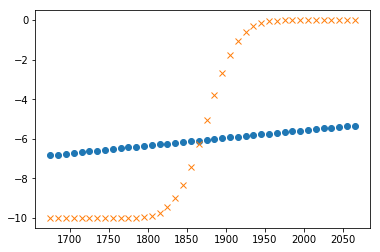

In [217]:
import numpy as np
import matplotlib.pyplot as plt

plt.plot(prices, spread_prices, "o")
plt.plot(prices, spread_prices_t, "x")
plt.show()

In [196]:
bull_put_spread(price, upper, lower, time)

9.998073588671105

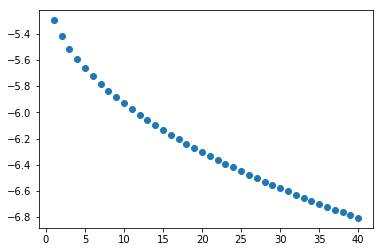

In [41]:
strike = 1875
upper = 1880
lower = 1870
samples = 40
price = 1875

_times = [samples-i for i in range(samples)]
times = [(samples-i)/365 for i in range(samples)]
options =  [get_option_price(price, strike, time) for time in times]
spread_prices =  [bull_put_spread(price, upper, lower, time) for time in times]

import numpy as np
import matplotlib.pyplot as plt

plt.plot(_times, spread_prices, "o")
#plt.plot(prices, spread_prices_t, "x")
plt.show()

In [50]:
spread_prices[-7]/spread_prices[-5]

1.0211092448439425

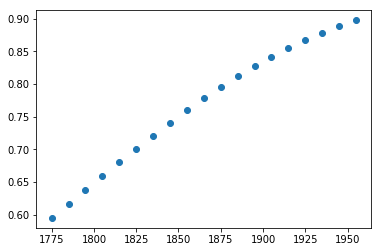

In [435]:
diffs = []
for i in range(len(calls)-1):
    diff = calls[i]/calls[i+1]
    diffs.append(diff)
plt.plot(prices[:-1], diffs, "o")
plt.show()